In [1]:
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents.schemas import BaseSchema
from config.selectionconfig import runsetting as rs

In [2]:
from analysis.selutility import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from config.selectionconfig import settings as sel_cfg

In [5]:
import os
os.environ['PARENT_DIR'] = "/uscms/homes/j/joyzhou/work/hhbbtautau/"

### Test on selutility.py

In [6]:
proc = Processor(rs)
proc.setdata()
(sample_fn, sample_part) = list(proc.data.items())[0]

There are 54 files to process in this dataset


In [22]:
sample_input = {sample_fn: {'object_path': 'Events', 'steps': [0,300]}}
events = proc.loadfile({sample_fn: "Events"}, entry_stop=10)

In [ ]:
import dask_awkward as dak
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=1, threads_per_worker=2)
client = Client(cluster)

In [23]:
type(events)

dask_awkward.lib.core.Array

### Dask Task Graph

/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39562 instead
  warnings.warn(


In [52]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39562/status,
Dashboard: http://127.0.0.1:39562/status,Workers: 2
Total threads: 4,Total memory: 11.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46828,Workers: 2
Dashboard: http://127.0.0.1:39562/status,Total threads: 4
Started: Just now,Total memory: 11.57 GiB
Comm: tcp://127.0.0.1:36500,Total threads: 2
Dashboard: http://127.0.0.1:34428/status,Memory: 5.79 GiB
Nanny: tcp://127.0.0.1:42440,


In [13]:
(sample_fn, sample_part) = list(proc.data.items())[0]

In [20]:
sample_part

{'object_path': 'Events', 'steps': [[0, 16065]]}

In [21]:
sample_input = {sample_fn: {'object_path': 'Events', 'steps': [0, 10000, 16065]}}
sample_input

{'root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv12/GluGlutoHHto2B2Tau_kl-0p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/Poisson60KeepRAW_130X_mcRun3_2022_realistic_postEE_v6-v2/2520000/a5835502-9cce-432a-a123-586d777b97f7.root': {'object_path': 'Events',
  'steps': [0, 10000, 16065]}}

In [22]:
events = proc.loadfile(sample_input)

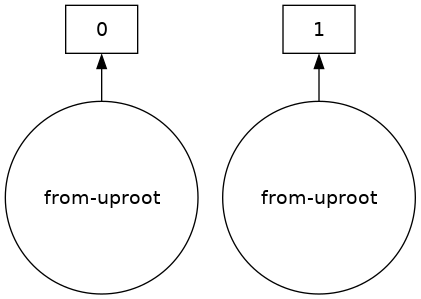

In [24]:
events.visualize()

In [35]:
lepcfg = proc.channelsel[0].selections
jetcfg = proc.commonsel
cfgname = proc.channelseq[0]

In [36]:
evtsel = EventSelections(lepcfg, jetcfg, cfgname)

In [37]:
evtsel.lepselsetter(events)

In [38]:
evtsel.objsel

PackedSelection(selections=('ElectronSelection', 'MuonSelection', 'TauSelection'), delayed_mode=True, items=3, maxitems=32)

In [39]:
passed, vetoed = evtsel.objselcaller(events)

In [47]:
passed.visualize(f'{rs.OUTPUTDIR_PATH}/sampletaskgraph.png')

In [7]:
cf_np, cf_lab = proc.res_to_np(cf)

In [8]:
cf_df = pd.DataFrame(data=cf_np, columns=proc.channelseq, index=cf_lab)

In [9]:
cf_df

,taumtauh,tauetauh,tauhtauh
initial,17901,16881,15105
ElectronSelection,11703,3445,10683
MuonSelection,1746,2848,8818
TauSelection,1020,1776,715


In [123]:
sels = EventSelections(sel_cfg.signal.channel1.selections, sel_cfg.signal.commonsel, "taumtauh")

In [124]:
channel_cfg = sel_cfg.signal.channel1.selections

In [125]:
sels.lepselsetter(events)

In [126]:
passed, vetoed = sels.objselcaller(events)

In [146]:
muon = Object("Muon", passed, output_cfg.Muon, sel_cfg.signal.channel1.selections.muon)

In [148]:
muon.to_daskdf()

,charge,tightid,pt,eta,phi,mass,dxy,dz,iso
0,-1,True,56.323387,-1.272949,-1.323242,0.105713,0.000142,0.000187,0.000000
1,-1,True,115.620300,-0.862549,-0.288086,0.105713,0.013359,0.001285,0.007867
2,-1,True,83.440041,0.466248,-2.513184,0.105713,0.010284,-0.016403,0.040061
3,1,True,45.711536,0.759766,-0.030220,0.105713,0.000232,0.000190,0.006112
4,-1,True,53.904057,1.698975,2.974121,0.105713,0.005543,0.004280,0.013304
...,...,...,...,...,...,...,...,...,...
1015,1,True,39.006180,-0.530029,0.324280,0.105713,0.010696,-0.003382,0.000000
1016,1,True,85.784004,-0.617065,1.502686,0.105713,0.000269,-0.001814,0.019560
1017,-1,True,26.654907,-0.143829,-0.517456,0.105713,0.004475,0.015450,0.046668
1018,-1,False,42.732983,-0.477112,-2.280762,0.105713,0.012665,-0.004086,0.300953


In [136]:
computed, = dask.compute(muon.dakzipped['pt'][:,0])

In [96]:
dask.array.concatenate(arr_list, axis=1)

ValueError: Tried to concatenate arrays with unknown shape (nan, nan).

Two solutions:
  1. Force concatenation pass allow_unknown_chunksizes=True.
  2. Compute shapes with [x.compute_chunk_sizes() for x in seq]

In [35]:
sels.objsel.cutflow(*sels.objsel.names).result().nevcutflow

[dask.awkward<count, type=Scalar, dtype=int64>,
 dask.awkward<sum, type=Scalar, dtype=int64>,
 dask.awkward<sum, type=Scalar, dtype=int64>,
 dask.awkward<sum, type=Scalar, dtype=int64>]

In [40]:
cutflow = sels.objsel.cutflow(*sels.objsel.names)

In [65]:
cutflow.result().labels

[autoreload of analysis.selutility failed: Traceback (most recent call last):
  File "/Users/yuntongzhou/miniconda3/envs/dev/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/yuntongzhou/miniconda3/envs/dev/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/yuntongzhou/miniconda3/envs/dev/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/yuntongzhou/Desktop/Dihiggszztt/HHtobbtautau/src/analysis/selutility.p

['initial', 'ElectronSelection', 'MuonSelection', 'TauSelection']

In [44]:
import dask

In [51]:
dask.compute(cutflow.result())

TypeError: tuple indices must be integers or slices, not str

In [47]:
res = cutflow.result().nevcutflow

In [48]:
res

[dask.awkward<count, type=Scalar, dtype=int64>,
 dask.awkward<sum, type=Scalar, dtype=int64>,
 dask.awkward<sum, type=Scalar, dtype=int64>,
 dask.awkward<sum, type=Scalar, dtype=int64>]

In [18]:
sels.leptonsel.all()

dask.awkward<equal, npartitions=1>

In [34]:
events = events[~(sels.leptonsel.all())]

In [17]:
type(events)

dask_awkward.lib.core.Array

In [40]:
cutflow.print()

/Users/yuntongzhou/miniconda3/envs/dev/lib/python3.9/site-packages/coffea/analysis_tools.py:845: UserWarning: Printing the cutflow statistics is going to compute dask_awkward objects.
  warnings.warn(


Cutflow stats:
Cut ElectronSelection   :pass = 11703               cumulative pass = 11703               all = 17901               -- eff = 65.4 %                    -- cumulative eff = 65.4 %
Cut MuonSelection       :pass = 2318                cumulative pass = 1746                all = 17901               -- eff = 12.9 %                    -- cumulative eff = 9.8 %
Cut TauSelection        :pass = 9305                cumulative pass = 1020                all = 17901               -- eff = 52.0 %                    -- cumulative eff = 5.7 %


In [47]:
res = cutflow.result().nevcutflow

In [48]:
res

[17901, 11703, 1746, 1020]

In [72]:
sels.lepselcfg

<Box: {'electron': {'veto': True, 'ptLevel': 25}, 'muon': {'veto': False, 'pt': 25, 'eta': 2.1, 'iso': 0.15, 'count': 1, 'dxy': 0.045, 'dz': 0.2}, 'tau': {'veto': False, 'pt': 35, 'eta': 2.3, 'IDvsjetLevel': 5, 'IDvsmuLevel': 4, 'IDvseLevel': 3, 'dz': 0.2, 'count': 1}, 'pair': {'name': 'MT', 'OS': True, 'dRLevel': 0.5}}>

In [11]:
def measure_execution_time(func, *args, **kwargs):
    start_time = time.perf_counter()  # Start timing

    # Call the function with any provided arguments
    result = func(*args, **kwargs)

    end_time = time.perf_counter()  # End timing
    execution_time = end_time - start_time

    print(f"The function '{func.__name__}' took {execution_time} seconds to execute.")
    return result

In [36]:
start_time = time.perf_counter()
events = NanoEventsFactory.from_root(
        f"{rs.SINGLE_PATH}:Events",
        entry_stop=None,
        metadata={"dataset": "DYJets"},
        uproot_options={"timeout": 100},
        schemaclass=BaseSchema,
    ).events()
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The function took {execution_time} seconds to execute.")

The function took 0.6647109169998657 seconds to execute.


In [59]:
jetpt = events["Jet_pt"].compute()
jeteta = events["Jet_eta"].compute()
dak_zipped = dak.zip({"pt": dak.from_awkward(jetpt, npartitions=10),
                      "eta": dak.from_awkward(jeteta, npartitions=10)})

In [16]:
start_time = time.perf_counter()  # Start timing
(dak.num(dak_zipped)==2).compute()
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The function took {execution_time} seconds to execute.")

The function took 0.02522283299981609 seconds to execute.


In [64]:
dak_zipped = dak_zipped[dak_zipped.pt>50]

In [65]:
dak_mask = dak.num(dak_zipped)>2

In [66]:
dak_zipped[dak_mask].compute()

<Array [[{pt: 195, eta: ..., ...}, ...], ...] type='8036 * var * {pt: float...'>

In [31]:
# correct way to compute events
events=events[dak_mask.compute()]

In [90]:
start_time = time.perf_counter()  # Start timing
(dak.num(events["Jet_pt"])==2).compute()
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"The function took {execution_time} seconds to execute.")

The function took 0.894880166000803 seconds to execute.


In [1]:
import numpy as np

In [2]:
acc_list = [None]*2
cf_list = [[2,1],[3,4]]
acc_list = [np.zeros(len(cf_list[j])) for j in range(2)]

In [59]:
import numpy as np
import dask.array as da

# Example 1D NumPy arrays
np_array1 = np.array([1, 2, 3, 4])
np_array2 = np.array([5, 6, 7, 8])

# Convert to 1D Dask arrays
dask_array1 = da.from_array(np_array1, chunks=len(np_array1) // 2)
dask_array2 = da.from_array(np_array2, chunks=len(np_array2) // 2)

# Add a new axis to make arrays 2D
dask_array1_2d = dask_array1[:, np.newaxis]
dask_array2_2d = dask_array2[:, np.newaxis]

# Concatenate along the second axis to form a 2D array with two columns
concatenated_array = da.concatenate([dask_array1_2d, dask_array2_2d], axis=1)

# Compute the concatenated array to get the result as a NumPy array
result = concatenated_array.compute()

print(result)

[[1 5]
 [2 6]
 [3 7]
 [4 8]]
